**Final Code submitted to Kaggle for model training**

Personal goals of this project were to:

    * showcase Tensorflow capabilities in a medium-scale image processing project
    * train models on multi-GPU and TPU platforms


## Prostate cancer diagnosis using the Gleason grading system ##

### Problem ###

The goal of this project is to identify the severity of the prostate cancer for given a biopsy image. 

The severity of cancer in a small patch of cancerous tissue is defined by the Gleason  Score. Though, the overall tissue sample might have multiple cancerous regions with different Gleason Scores. Thus, the severity of the cancer for the whole sample is graded differently (by ISUP Grades) as shown below.

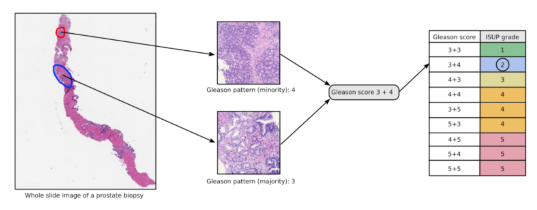

Cancerous cells have the following visual differences compared to a healthy cell:
*     Darker cytoplasm
*     Larger nuclei
*     Less number of hollow locations (glands)

### Work Flow ###

The following code is organized as:

    1) Image preprocessing
        * Reading, augmenting and tiling of the image to reduce white regions  
        
    2) Data Pipeline Construction
        * Startified K-Fold creation and batching
        
    3) Model Training
        * Transfer Model learning with EfficientNet B0 model
    
Inference on the test data is done on a seperate notebook    

In [1]:
import tensorflow as tf
import pathlib,os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import skimage.io
from sklearn.model_selection import StratifiedKFold
import time
import albumentations
import tensorflow_addons as tfa
import tensorflow_hub as hub
from tensorflow.keras import layers,models
AUTOTUNE = tf.data.experimental.AUTOTUNE

import random as python_random
np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(1234)
os.environ['PYTHONHASHSEED']=str(0)

tf.get_logger().setLevel('ERROR')  # to suppress warning messages


In [2]:
#tf.debugging.set_log_device_placement(True)  # to see which devices are used. Has to be on top of the code

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')),'\n')
for dev in tf.config.list_physical_devices(device_type=None):    print(dev.name)

Num GPUs Available:  8 

/physical_device:CPU:0
/physical_device:XLA_CPU:0
/physical_device:XLA_GPU:0
/physical_device:XLA_GPU:1
/physical_device:XLA_GPU:2
/physical_device:XLA_GPU:3
/physical_device:XLA_GPU:4
/physical_device:XLA_GPU:5
/physical_device:XLA_GPU:6
/physical_device:XLA_GPU:7
/physical_device:GPU:0
/physical_device:GPU:1
/physical_device:GPU:2
/physical_device:GPU:3
/physical_device:GPU:4
/physical_device:GPU:5
/physical_device:GPU:6
/physical_device:GPU:7


In [3]:
kaggle_data= '/data/users/rpravahan/panda'

data_dir=kaggle_data+'/train_images'
data_simple_dir='/home/emungan/panda/data_simple/images'
ds_dir = pathlib.Path(data_simple_dir)

label_dir=kaggle_data+'/train.csv'
train_labels = pd.read_csv(label_dir).set_index('image_id')

### Data Cleanup ###

Following images are removed from the datasets either because they were 
*     Empty
*     Medically incorrect samples
*     Duplicates of other images

In [4]:
black_list= ['3790f55cad63053e956fb73027179707','014006841b9807edc0ff277c4ab29b91','00d8a8c04886379e266406fdeff81c45','6f310463d3868e86be87adddeccdde19', '6ef357192c2530ee54e1bd38a3231e00', '511a33b7aeb1153407ed2d55cae001c8', '2fb68d6713a52e322692dbc99ac82444', '8a415b0e974861fa00ae9d88f9e3b980', 'eda92317b583435a810cac1dc7bb8025', 'c9dbdd9c9fc0eab0d235499488b26c53', '99d9afb22b65ea97fcd21ce67e1ddb6c', '0c46c60ae2ef49657bc843707162ba6e', '85b7018a9e5287342a1392fb02ce24a1', '4e80b5738f591c7d0d91889c2bdfd39d', 'f13cd8ec6e6fde523a0a065b62086d3c', 'aebe292567e0f8447fdc94994189a80a', '6b512a45bd8ca759e655c2d551dec2d9', 'be403ce415609008605d63396869ed2e', 'e3360926180928287a4d96973e10926a', '3752b697cae9f81a9d5ffe44dac58e7a', 'a0ac3589042f9e99d31b521b5b56ac06', 'f5675cb89a120e225ca8929b64a5af79', '6d569809f11e6e53918dfb1609fb0d83', '7817ae2d392ba4f6cb9104fbe70b6274', 'cd382fdc26516c634b2314aa870bfe80', '1cdd6def1e3099a9763938457cf0b4be', '0186f4811c9d089707d9dc7460160d88', 'e9d628364cf51891028163e0cfca628c', '9effeea56c413b92340b89d1240769c1', '7a0a36bc6119e3d78474e6c8ca875725', '374d5401159d9bf39ce20b395d82c0b4', '7fa4634ab59a7832bc877fef162eacaa', 'ee182a14e532b122f40d561d87eb2136', 'c0a0956a39319920d02c5c4eb30c5e10', '441265c6b4598e9bcd10bc10eb6293cc', '8ae069858aecbad846f4d69d405f9bd6', 'b13961504ea859ff34a150bc19fed335', '476f0dfb144aee7d5422dcc3b2b97a9f', 'bc93d165d96e4fa4883f130b3f7b9885', 'ac9d05fa3f4fafb474fb96f9f8ab71ac', '1438f19e07c389b47fd5219ca62f9f0a', '479200a381febadfd767615fbe77c3ea', 'fc6a695ba44f4b64425c522f590bac48', '046bac77a58c1be84a6418904e755280', '5c083ab21fc57c0954468ab46aa7fb16', 'cca735c397880e88192e97d68b97754e', 'a579110fe1e670847d9d146404597750', '8dbedd97ed2b7b01525d6800d52ae073', '004dd32d9cd167d9cc31c13b704498af', 'cdf40333dfe2afec1a4c54d9eeb1ec7a', '09d4be69a2330cd49298bf30d29cc4e5', 'f73951fddf77034c9fd44cb19f5fe6b5', 'aef75d4c390d838aabe56e2d601b6a13', 'b3a2dc7547bc580c6f3923c61db42051', '774c9b631a29f191836b1078a6c3a67c', '836ca5d73c88ad94fb980ca3e5e65da7', 'bfdbe56fb7fc4d7b3d151370f897d503', '06ef49a7b77e883f089cfdd80642d6f0', '8e25584bd03155d24a2adc00517a38e8', 'dc2ec851fcbf594f11b023387ac15003', 'a0150f4d6d9f6f3b2b5a240b099df000']
train_labels=train_labels.drop(black_list)
display(train_labels)

,data_provider,isup_grade,gleason_score
image_id,,,
0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0
...,...,...,...
ffd2841373b39792ab0c84cccd066e31,radboud,0,negative
ffdc59cd580a1468eac0e6a32dd1ff2d,radboud,5,4+5
ffe06afd66a93258f8fabdef6044e181,radboud,0,negative


### Data Preprocessing ###


In [5]:
def read_tiff(img_path_tensor,level):      
 
    '''Read the image and get the label'''
    img_path = img_path_tensor.numpy().decode("utf-8")     #input needs to be a tensor, skimage wants a string to iterate over
    img      = skimage.io.MultiImage(str(img_path))[level]
    im_ID    = img_path.split(os.sep)[-1].split('.')[0]
    label    = train_labels.loc[im_ID,'isup_grade']        # get the label from the csv file
                                                           # make sure the output type is updated in open_crop_tiff                                                           
    return img, label


def augment(image_array):
    
    '''Augmentations'''    
    op_train = albumentations.Compose([
        albumentations.VerticalFlip(p=0.5),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.Rotate(limit=90,border_mode=4,p=0.5),    #mode 1 wraps around
        #albumentations.ElasticTransform(alpha=1, sigma=50, alpha_affine=50,p=0.5),
        albumentations.HueSaturationValue(hue_shift_limit=(0,20), sat_shift_limit=0, val_shift_limit=0,p=0.5),
        #albumentations.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20,p=0.5),
        albumentations.GaussianBlur(blur_limit=3,p=0.25)
    ])  
    
    return op_train(image=image_array)['image']        


def tile_tiff(img,level,n_tiles):
    """Create a patchwork from tissue patches"""    
    
    if (level==1): tile_size=256                          # tile size depends on the downsampling of the level
    elif (level == 2): tile_size =128
    else: raise Exception("level is not 1 or 2")
    
    mode=0
    sub_imgs=False
    is_rand=False
    
    tiles = []
    h, w, c = img.shape
    pad_h = (tile_size - h % tile_size) % tile_size + ((tile_size * mode) // 2)
    pad_w = (tile_size - w % tile_size) % tile_size + ((tile_size * mode) // 2)

    img2 = np.pad(img,[[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2,pad_w - pad_w//2], [0,0]], constant_values=255)
    img3 = img2.reshape(img2.shape[0] // tile_size,tile_size,img2.shape[1] // tile_size,tile_size, 3)
    
    img3 = img3.transpose(0,2,1,3,4).reshape(-1, tile_size, tile_size,3)
    n_tiles_with_info = (img3.reshape(img3.shape[0],-1).sum(1) < tile_size ** 2 * 3 * 255).sum()
    if len(img) < n_tiles:
        img3 = np.pad(img3,[[0,N-len(img3)],[0,0],[0,0],[0,0]], constant_values=255)
    idxs = np.argsort(img3.reshape(img3.shape[0],-1).sum(-1))[:n_tiles]
    img3 = img3[idxs]
    for i in range(len(img3)):
        tiles.append({'img':img3[i], 'idx':i})
        
    # create the patchwork  
    if is_rand:
        idxes = np.random.choice(list(range(n_tiles)), n_tiles, replace=False)
    else:
        idxes = list(range(n_tiles))
    idxes = np.asarray(idxes) + n_tiles if sub_imgs else idxes

    n_row_tiles = int(np.sqrt(n_tiles))
    images = np.zeros((tile_size * n_row_tiles, tile_size * n_row_tiles, 3))
    for h in range(n_row_tiles):
        for w in range(n_row_tiles):
            i = h * n_row_tiles + w
    
            if len(tiles) > idxes[i]:
               this_img = tiles[idxes[i]]['img']
            else:
                this_img = np.ones((tile_size, tile_size, 3)).astype(np.uint8) * 255
            this_img = 255 - this_img
            h1 = h * tile_size
            w1 = w * tile_size
            images[h1:h1+tile_size, w1:w1+tile_size] = this_img

    images = 255 - images
    images = images.astype(np.float32)
    images /= 255                                              # no need to normalize later
    
    return images

def tile_and_aug_tiff(img_path_tensor,level,aug,n_tiles):      
    '''combining three python functions to be wrapped'''
    
    #read and get the label
    img,label = read_tiff(img_path_tensor,level)
    
    # Augment the image
    if(aug): img= augment(img)

    # get the patches with tissue    
    images=tile_tiff(img,level,n_tiles)
    
    return images,label


def tile_aug_tiff(image_path,level,aug,n_tiles):  #inputs should be tensors
    
    [image,label] = tf.py_function(tile_and_aug_tiff,[image_path,level,aug,n_tiles],[tf.float32,tf.int8])
    im_shape = image.shape
    image.set_shape(im_shape)
    
    return image,label  

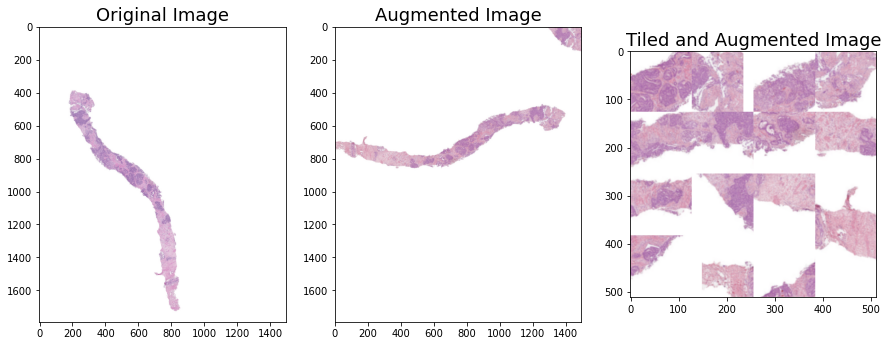

In [6]:
'''single test case for augmentation and tiling'''

if(1):
    image_num='001c62abd11fa4b57bf7a6c603a11bb9'
    img_path=os.path.join(data_simple_dir, image_num+'.tiff')
    path_tensor= tf.constant(img_path)

    level=2             # tile size 256 for level =1, 128 for level=2
    n_tiles= 16
    
    orig       = skimage.io.MultiImage(str(img_path))[level]
    aug_img    = augment(orig)
    tile       = tile_tiff(aug_img,level,n_tiles)
        
    fig, [ax1,ax2,ax3]=plt.subplots(1, 3,figsize=(15,10))
    ax1.imshow(orig)
    ax1.set_title('Original Image',fontsize=18)

    ax2.imshow(aug_img)
    ax2.set_title('Augmented Image',fontsize=18)

    ax3.imshow(tile)
    ax3.set_title('Tiled and Augmented Image',fontsize=18)


### Data Pipeline ###

In [7]:
def create_folds(train_labels,n_fold):
    """ Create Stratified K Folds"""
    
    input_DF= train_labels.copy().reset_index(drop=False) # drop the image_ID as the index so that the you can index with skf's results

    skf=StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
    for f, (train_idx,test_idx) in enumerate(skf.split(input_DF,input_DF['isup_grade'])):
        input_DF.loc[test_idx,'test_fold']= f  #setting wrt test data indexes as they don't overlap
  
    return input_DF

In [8]:
create_folds(train_labels,n_fold=5)

,image_id,data_provider,isup_grade,gleason_score,test_fold
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,1.0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,4.0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,3.0
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,0.0
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,2.0
...,...,...,...,...,...
10550,ffd2841373b39792ab0c84cccd066e31,radboud,0,negative,2.0
10551,ffdc59cd580a1468eac0e6a32dd1ff2d,radboud,5,4+5,3.0
10552,ffe06afd66a93258f8fabdef6044e181,radboud,0,negative,1.0
10553,ffe236a25d4cbed59438220799920749,radboud,2,3+4,2.0


In [9]:
def get_train_test_list(fold, labels_DF,debug=0):
    """Get the file path list for train and validation sets"""
    
    train_list=[]
    im_ID_train=labels_DF.loc[labels_DF['test_fold']!=fold,'image_id']
    for ID in im_ID_train:   train_list.append(os.path.join(data_dir,ID+'.tiff')) # changed from data_simple to data dir
    if(debug): 
        print('train')
        for i in train_list[0:2]: print(i)
        print("Num of samples: ",len(train_list),"\n")

    test_list=[]
    im_ID_test=labels_DF.loc[labels_DF['test_fold']==fold,'image_id']
    for ID in im_ID_test:   test_list.append(os.path.join(data_dir,ID+'.tiff'))  # changed from data_simple to data dir
    if(debug): 
        print('test')
        for i in test_list[0:2]: print(i)
        print("Num of samples: ",len(test_list))

    return train_list, test_list



@tf.autograph.experimental.do_not_convert   # ow gives out a lot of warnings..

def create_batches(path_list, level, subset_ratio, batch_size,n_tiles, tiled_input=1, debug=0, aug=0):
    
    dataset = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(path_list,tf.string))
    if (debug): list(dataset.as_numpy_iterator())  
    
    if(tiled_input):
        batches = (
            dataset
            .cache()
            .shuffle(len(path_list))  
            .take(int(len(path_list)*subset_ratio))
            .map(lambda x: tile_aug_tiff(x,tf.constant(level),tf.constant(aug),tf.constant(n_tiles)),num_parallel_calls=AUTOTUNE )
            .batch(batch_size)
            .prefetch(AUTOTUNE)
        )
    
    return batches 


def get_batches(input_DF,fold,level, subset_ratio, batch_size, n_tiles,tiled_input, debug,aug):

    labels_DF=input_DF.copy()
    tic = time.perf_counter()

    train_paths, test_paths= get_train_test_list(fold, labels_DF,debug)
    train_batches = create_batches(train_paths, level, subset_ratio, batch_size,n_tiles, tiled_input, debug, aug)
    test_batches  = create_batches(test_paths,  level, subset_ratio, batch_size,n_tiles, tiled_input, debug )       # no augmentation here

    if(debug): 
        print('\nTraining on {} samples'.format(int(len(train_paths)*subset_ratio)))
        for images, labels in train_batches.take(1): 
                #show(images[0], labels[0])                        # takes long to plot
                #print(np.unique(images[0]))                       # check whether it is normalized
                print('Batch and label sizes: ',images.numpy().shape, labels.numpy().shape)  # check dims

    toc = time.perf_counter()
    dt  = toc-tic
    print(f"Operation took {dt//3600:0.0f} hours {(dt-((dt//3600)*3600))//60:0.0f} minutes {dt%60:0.4f} seconds\n")
    
    return train_batches,test_batches

### Model Training ###

In [10]:
def define_model(gpus_to_use):
    """Transfer Learning with Efficient Net B0 Model on GPU"""
    
    mirrored_strategy = tf.distribute.MirroredStrategy(devices=gpus_to_use)
    with mirrored_strategy.scope():
        feature_extractor_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1" 
        feature_extractor_layer = hub.KerasLayer(feature_extractor_url,input_shape=(input_dimx,input_dimy,3))
        feature_extractor_layer.trainable = True

        model = tf.keras.Sequential([
          feature_extractor_layer,
          layers.Dense(6)
        ])

        model.summary()

        model.compile(
          optimizer=tf.keras.optimizers.Adam(),
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['sparse_categorical_accuracy']
          #metrics=[tfa.metrics.CohenKappa(weightage='quadratic', num_classes=6,sparse_labels=True),'sparse_categorical_accuracy' ]
        )
    
    return model



def run_training(model,train_batches,test_batches,n_epochs):

    tic = time.perf_counter()

    history = model.fit(train_batches, epochs=n_epochs, validation_data=test_batches)

    toc = time.perf_counter()
    dt  = toc-tic
    print(f"Operation took {dt//3600:0.0f} hours {(dt-((dt//3600)*3600))//60:0.0f} minutes {dt%60:0.4f} seconds\n")
    
    return model, history

def save_whole_model(model,model_filepath):

    tf.keras.models.save_model(
        model,
        model_filepath,
        overwrite=True,
        include_optimizer=True,
        save_format=None,
        signatures=None,
        options=None
    )
    
    print(model,' is saved')

### Putting the Model Together ###

We'll create tiles of 25 squares from level 2 of the tiff image and run it by the EfficientNet model with batches of 16

In [11]:
n_fold=5
level=2                        
batch_size=16
subset_ratio=1                 # can use a subset of the training data
tiled_input=1                  # image is tiled instead of cropped and padded
n_tiles=25
debug=1
aug=1

if(level==1):    input_dimx= int((n_tiles**0.5)*256)
elif(level==2):  input_dimx= int((n_tiles**0.5)*128)
else:            raise Exception("level is not 1 or 2")
input_dimy=input_dimx

n_epochs=20
gpus_to_use= ["/gpu:4","/gpu:5","/gpu:6","/gpu:7"]


input_DF=create_folds(train_labels,n_fold)
for fold in range(0,1):
    print("\n\nFOLD "+str(fold)+"\n\n")
    train_batches,test_batches= get_batches(input_DF,fold,level, subset_ratio, batch_size, n_tiles,tiled_input, debug,aug)
    efnet_b0 = define_model(gpus_to_use)
    efnet_b0,history= run_training(efnet_b0,train_batches,test_batches,n_epochs)
    model_filepath= '/home/emungan/panda/saved_models/KFold_fold'+str(fold)
    save_whole_model(efnet_b0,model_filepath)



FOLD 0


train
/data/users/rpravahan/panda/train_images/0005f7aaab2800f6170c399693a96917.tiff
/data/users/rpravahan/panda/train_images/000920ad0b612851f8e01bcc880d9b3d.tiff
Num of samples:  8444 

test
/data/users/rpravahan/panda/train_images/001c62abd11fa4b57bf7a6c603a11bb9.tiff
/data/users/rpravahan/panda/train_images/003046e27c8ead3e3db155780dc5498e.tiff
Num of samples:  2111

Training on 8444 samples
Batch and label sizes:  (16, 640, 640, 3) (16,)
Operation took 0 hours 0 minutes 4.4858 seconds

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              4049564   
_________________________________________________________________
dense (Dense)                (None, 6)                 7686      
Total params: 4,057,250
Trainable params: 4,015,234
Non-trainable params: 42,016
______________________________________________________________

In [12]:
!pwd
!ls 

/home/emungan/panda/codes
Augment_v1.ipynb     Dataset_v3.ipynb	     Label_stats.ipynb
Augment_v2.ipynb     Image Preview.ipynb     Model_mobilenet.ipynb
Data_Analysis.ipynb  Image Stats.ipynb	     Model_v9.ipynb
Data_cleanup.ipynb   K-Fold Inference.ipynb  Panda Inference v2.ipynb
Dataset_v1.ipynb     K-Fold.ipynb
Dataset_v2.ipynb     K-Fold_out.ipynb
